# Neural Network Performance on Spectral Clustering

### Import Packages

In [1]:
# tensorflow model imports
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# keras imports
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

# sklearn modeling imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import AffinityPropagation, KMeans, SpectralClustering

# other imports
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/spotify_tracks_genre.csv')

### Preprocessing

In [4]:
data = data.drop(labels = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'],
                 axis = 1)

data["explicit"] = data["explicit"].replace({True:1, False:0})

# adding one-hot encoding of our categorical column time signature and key
data = pd.get_dummies(data, columns = ["time_signature","key"])

In [5]:
data

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,73,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,0
1,55,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,0
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,1,0,0,0,0,0,0
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,0,0
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,0,0
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Spectral Clustering

average_traits_by_genre = data.groupby('track_genre').mean()

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(average_traits_by_genre)

data_scaled = pd.DataFrame(scaled_features, columns=average_traits_by_genre.columns,
                           index=average_traits_by_genre.index)

# 20 clusters
num_clusters = 20
spectral = SpectralClustering(n_clusters=num_clusters, random_state=42, n_init=10)
average_traits_by_genre['cluster'] = spectral.fit_predict(scaled_features)

#display clusters
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    genres_in_cluster = average_traits_by_genre[average_traits_by_genre['cluster'] == cluster].index.tolist()
    print(genres_in_cluster)
    print()

Cluster 0:
['chill', 'garage', 'power-pop', 'psych-rock', 'rock', 'sad', 'ska', 'spanish', 'study', 'swedish', 'synth-pop']

Cluster 1:
['afrobeat', 'blues', 'club', 'country', 'disco', 'forro', 'j-idol', 'j-pop', 'j-rock', 'kids', 'party', 'punk', 'punk-rock', 'r-n-b', 'rockabilly', 'salsa']

Cluster 2:
['sleep']

Cluster 3:
['comedy']

Cluster 4:
['romance', 'tango']

Cluster 5:
['ambient', 'classical', 'new-age']

Cluster 6:
['alt-rock', 'alternative', 'anime', 'british', 'deep-house', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'french', 'german', 'goth', 'groove', 'grunge', 'hard-rock', 'hardcore', 'heavy-metal', 'house', 'industrial', 'k-pop', 'metal', 'pop', 'progressive-house', 'trip-hop', 'turkish']

Cluster 7:
['chicago-house', 'detroit-techno']

Cluster 8:
['jazz', 'soul']

Cluster 9:
['idm', 'iranian']

Cluster 10:
['bluegrass', 'mpb', 'pagode', 'samba', 'sertanejo']

Cluster 11:
['dance', 'hip-hop', 'latin', 'latino', 'reggae', 'reggaeton']

Cluster 12:
['disn

In [7]:
# relabeling genres
for i in range(num_clusters):
  genres_in_cluster = average_traits_by_genre[average_traits_by_genre['cluster'] == i].index.tolist()
  if len(genres_in_cluster) == 0:
    break
  data = data.replace(genres_in_cluster, i)

# undersampling 1000 from each cluster
sampled_df = pd.DataFrame()
n = len(data["track_genre"].unique())
for i in range(n): # sample 1000
  cluster = data[data["track_genre"] == i]
  samples = cluster.sample(1000)
  sampled_df = pd.concat([sampled_df, samples], axis=0)

data = sampled_df

In [8]:
# train test split
X = data.drop(labels=['track_genre'], axis=1)
y = data['track_genre']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

n = int(len(data)/1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Construction

In [9]:
# FCNN model
num_features = X_train.shape[1]
num_genres = np.unique(y_train).shape[0]

def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(num_features,)))
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = activation))
    model.add(Dense(num_genres, activation = 'softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
model = create_model()

### Training

In [11]:
# scheduler to fine tune model learning
def scheduler(epoch, lr):
  return lr*0.9

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, batch_size = 32, verbose=1, epochs=20,
           validation_split=0.1, callbacks = [callback])

Epoch 1/20
450/450 [==============================] - 5s 7ms/step - loss: 1.9053 - accuracy: 0.3919 - val_loss: 1.7313 - val_accuracy: 0.4525 - lr: 9.0000e-04
Epoch 2/20
450/450 [==============================] - 2s 6ms/step - loss: 1.6442 - accuracy: 0.4708 - val_loss: 1.6675 - val_accuracy: 0.4681 - lr: 8.1000e-04
Epoch 3/20
450/450 [==============================] - 3s 6ms/step - loss: 1.5636 - accuracy: 0.4994 - val_loss: 1.5653 - val_accuracy: 0.4969 - lr: 7.2900e-04
Epoch 4/20
450/450 [==============================] - 3s 7ms/step - loss: 1.5103 - accuracy: 0.5140 - val_loss: 1.5197 - val_accuracy: 0.5081 - lr: 6.5610e-04
Epoch 5/20
450/450 [==============================] - 3s 7ms/step - loss: 1.4711 - accuracy: 0.5248 - val_loss: 1.5001 - val_accuracy: 0.5181 - lr: 5.9049e-04
Epoch 6/20
450/450 [==============================] - 4s 8ms/step - loss: 1.4212 - accuracy: 0.5409 - val_loss: 1.4543 - val_accuracy: 0.5344 - lr: 5.3144e-04
Epoch 7/20
450/450 [==========================

### Testing

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

125/125 [==============================] - 0s 2ms/step - loss: 1.4148 - accuracy: 0.5577
Test Loss: 1.4148046970367432
Test Accuracy: 0.5577499866485596


### Evaluation

125/125 [==============================] - 0s 2ms/step


Text(50.722222222222214, 0.5, 'True Label')

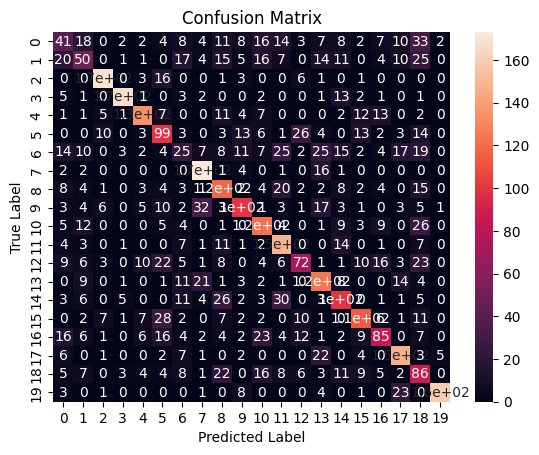

In [13]:
# confusion matrix to evaluate predictions
ypred = model.predict(X_test).argmax(axis=1)
cf_matrix = sklearn.metrics.confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

From the confusion matrix, we can see that our model performed very well particularly on clusters 2, 3, and 7. Inspecting what genres are in these clusters, we see that 2 and 3 both only have one cluster in them and appear to be statistically unique from the other genres in a cluster of their own. Cluster 7 is comprised of "chicago-house" and "detroit-techno" which our other clustering algorithms consistently clustered together. Our model did not perform well on clusters 0, 1, and 6, which when looking at the respective genres included, we see that they are rather large clusters and likely contain a lot of variability within.

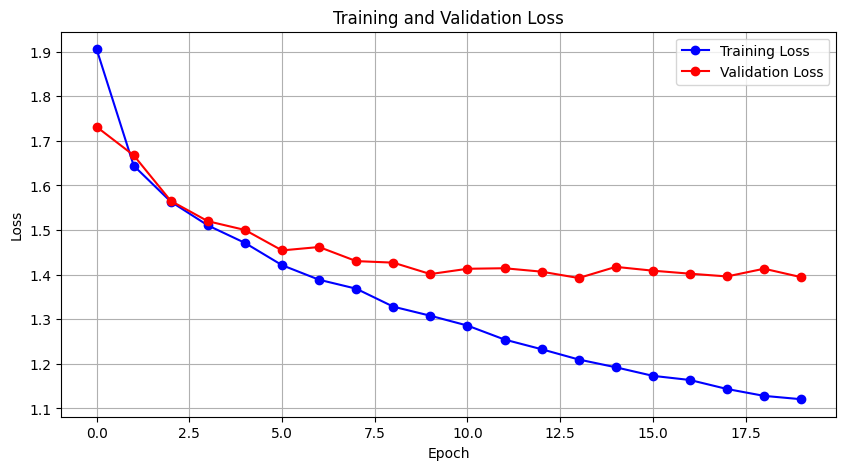

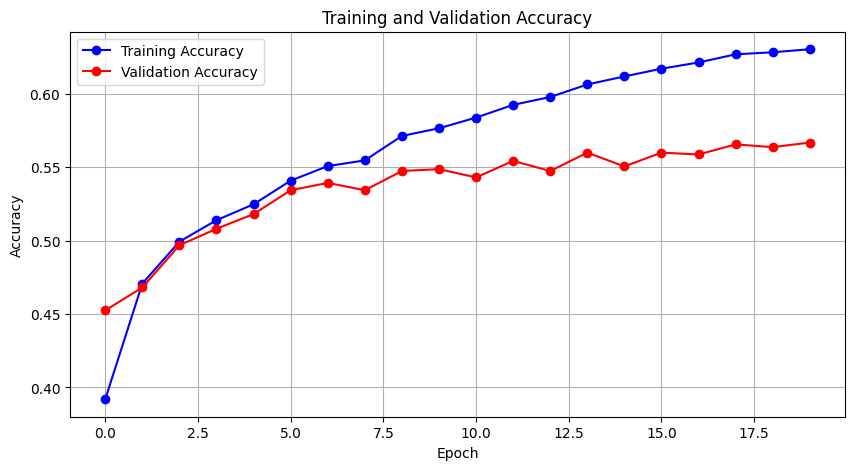

In [14]:
# extracting training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# extracting training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()